Interactive lab experiment parameterization widget

In [1]:
import netCDF4 as nc4
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib 
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import HBox, VBox
from IPython.display import display
from datetime import datetime, timedelta, date
import warnings
import math
from functools import partial # so that we cna pass arguments to callbacks


Using matplotlib backend: module://matplotlib_inline.backend_inline


## Functions

Function to solve the dispersion relation (dispersi):

**DISPERSION RELATION**
* Phase velocity of wave depends on frequency
* Low freq/long period waves have greater propagation speed

_Variables_: omega (radian freq), water depth, gravity, wavenumber


In [2]:
def dispersi(const):
    """
    Solve the linear dispersion relationship for surface gravity waves.

    Input:
        const = omega^2 * h / g, where:
            omega = radian frequency,
            h = water depth,
            g = acceleration due to gravity.
    Output:
        kh = wavenumber times water depth.
    Notes: Solves omega^2 * h / g = kh * tanh(kh) using Newton-Raphson iteration.
    
    Code to compute omega from frequency or period:
          g = 9.81
          omega = 2 * np.pi * f = 2 * np.pi / T
          const = (omega ** 2) * h / g
    Code to compute wavelength from kh:
          k = kh / h
          L = 2 * np.pi / k

    Code modified by C.M.Baker on Oct 2024
    """

    # Convert input to array, ensuring it's at least 1D
    const = np.atleast_1d(const)

    # Set negative values to NaN to avoid sqrt warning, assuming they are invalid
    const = np.where(const < 0, np.nan, const)

    # Initialize kh with zeros where const is zero, else with sqrt(const) as initial guess
    kh = np.where(const == 0, 0, np.sqrt(const))

    # Newton-Raphson iteration
    tolerance = 1e-6
    max_iterations = 100
    for _ in range(max_iterations):
        delta = (kh * np.tanh(kh) - const) / (np.tanh(kh) + kh / np.cosh(kh)**2)
        kh -= delta
        if np.all(np.abs(delta) < tolerance):
            break

    return kh

In [3]:
def calc_omega_k(f, h):
    """ 
    f = frequency
    h = water depth 
    
    Example usage:
    [omega, k] = calc_omega_k(frequency_value, water_depth_value)
    """
    
    # Constants
    g = 9.81
    
    # Angular frequency calculation
    omega = 2 * np.pi / (f ** (-1))
    
    # Constants calculation
    cons = omega ** 2 * h / g
    
    # Call to dispersi function (assuming it's defined elsewhere)
    kh = dispersi(cons)
    
    # Calculate k
    k = kh / h
    
    return omega, float(k[0])

### WAVE SHOALING
* Change in shape (steepening) and behavior (decreased wave speed and length) as wave passes through decreasing depth waters
* wo

_Edit history_:
* 11/5/24 (AJ) - added list of inputs/outputs to head of function

In [4]:
def waveshoal_h_nonmono(T, H0, theta0, gamma, h):
    """
    Code modified from M.Moulton on April 2, 2023
    
    Nonmonotonic wave shoaling (can shoal and de-shoal - e.g., bathy has bar and dip)
    
    Input:
        T: offshore period
        H0: deep water wave height
        theta0: offshore wave angle relative to beach (amount it's off from being perpendicular to the beach face)
        gamma: breaking index (short wave height to water depth)
        h: water depth
        
    Look at Snell's Law
    """
    
    # Suppress RuntimeWarning
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    # Constants
    g = 9.81  # m/s^2

    # Calculate wavelengths in deep water at depths h

    # Deep water wavelength:
    Ldeep = g * T**2 / (2 * np.pi)

    # Wavelength, Ole Madsen approx:
    L = Ldeep * (1 - np.exp(-(2 * np.pi * h / Ldeep)**1.25))**0.4
    

    # Calculate group and phase speeds at depths h
    c = L / T  # Phase speed; i.e., wavelength / period
    k = 2 * np.pi / L  # Wavenumber; i.e., radians per unit distance
    cg = (L / (2 * T)) * (1 + 2 * (k) * h / np.sinh(2 * (k) * h))  # Group velocity - notes: L/2T is k; rearranged version of dispersion relation

    # Calculate group and phase speeds at depth h0
    c0 = c[0]  # Phase speed at depth h0    (wave celerity)
    cg0 = cg[0]  # Group speed at depth h0  (wave group velocity)

    # Compute wave height and angle at depths h
    theta = np.arcsin(c / c0 * np.sin(np.radians(theta0)))
    H = H0 * np.sqrt(cg0 / cg) * np.sqrt(np.cos(np.abs(np.radians(theta0))) / np.cos(np.abs(np.radians(theta))))

    # Calculate breaking variables
    breaking_index = np.where(H / h > gamma)[0] # index of vector
    breaking_index = breaking_index[0]
    breaking_depth = h[breaking_index]
    breaking_height = H[breaking_index]
    breaking_angle = np.degrees(theta[breaking_index])

    # NaN values above shoreline
    theta[h < 0] = np.nan
    H[h < 0] = np.nan
    L[h < 0] = np.nan
    c[h < 0] = np.nan
    cg[h < 0] = np.nan

    # Store variables
    wave = {'h': h,
            'L': L,
            'Ldeep': Ldeep,
            'H': H,
            'c': c,
            'cg': cg,
            'theta': np.degrees(theta),
            'breaking_depth': breaking_depth,
            'breaking_height': breaking_height,
            'breaking_angle': breaking_angle,
            'breaking_index': breaking_index}

    # Compute profile onshore of breaking
    H[breaking_index] = h[breaking_index] * gamma
    binds = np.arange(breaking_index, len(h) - 1)

    for ii in binds:
        if h[ii + 1] < h[ii]:
            # Depth-limited breaking
            H[ii + 1] = h[ii + 1] * gamma
        else:
            # Re-shoaling - if threshold not exceeded
            h_2 = h[ii:]
            H0_2 = H[ii]
            theta0_2 = np.degrees(theta[ii])

            wave_2 = waveshoal_subf(T, H0_2, theta0_2, gamma, h_2)

            H_2 = wave_2['H']
            theta_2 = wave_2['theta']
            breaking_index2 = wave_2['breaking_index']

            # Fill in values
            H[ii:] = H_2
            theta[ii:] = theta_2

            # Second breaking region
            H[ii + breaking_index2:] = h[ii + breaking_index2:] * gamma

            break

    # NaN values above shoreline
    theta[h < 0] = np.nan
    H[h < 0] = np.nan

    wave['H'] = H
    wave['theta'] = np.degrees(theta)
    
    # AReset the warnings
    warnings.resetwarnings()

    return wave

def waveshoal_subf(T, H0, theta0, gamma, h):
    # subf = subfunction
    # this looks nearly identical shoaling waves up to breakpoint
    
    # Constants
    g = 9.81  # m/s^2

    # Calculate wavelengths in deep water at depths h

    # Deep water wavelength:
    Ldeep = g * T**2 / (2 * np.pi)

    # Wavelength, Ole Madsen approx:
    L = Ldeep * (1 - np.exp(-(2 * np.pi * h / Ldeep)**1.25))**0.4

    # Calculate group and phase speeds at depths h
    c = L / T  # Phase speed
    k = 2 * np.pi / L  # Wavenumber
    cg = (L / (2 * T)) * (1 + 2 * (k) * h / np.sinh(2 * (k) * h))  # Group velocity

    # Calculate group and phase speeds at depth h0
    c0 = c[0]  # Phase speed at depth h0
    cg0 = cg[0]  # Phase speed at depth h0

    # Compute wave height and angle at depths h
    theta = np.arcsin(c / c0 * np.sin(np.radians(theta0)))
    H = H0 * np.sqrt(cg0 / cg) * np.sqrt(np.cos(np.abs(np.radians(theta0))) / np.cos(np.abs(np.radians(theta))))

    # NaN values above shoreline
    theta[h < 0] = np.nan
    H[h < 0] = np.nan
    L[h < 0] = np.nan
    c[h < 0] = np.nan
    cg[h < 0] = np.nan

    # Calculate breaking variables
    breaking_index = np.where(H / h > gamma)[0]
    breaking_index = breaking_index[0]
    breaking_depth = h[breaking_index]
    breaking_height = H[breaking_index]
    breaking_angle = np.degrees(theta[breaking_index])

    # Store variables
    wave_sub = {'h': h,
                'L': L,
                'Ldeep': Ldeep,
                'H': H,
                'c': c,
                'cg': cg,
                'theta': np.degrees(theta),
                'breaking_depth': breaking_depth,
                'breaking_height': breaking_height,
                'breaking_angle': breaking_angle,
                'breaking_index': breaking_index}

    return wave_sub


#### Indexing, unit conversion

In [5]:
def find_closest_index(lst, target):
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    return closest_index

def indices_between(lst, lower_bound, upper_bound):
    between_indices = [i for i, x in enumerate(lst) if lower_bound < x < upper_bound]
    return between_indices

def ft2m(feet):
    meters = feet * 0.3048  # 1 foot is approximately equal to 0.3048 meters
    return meters

### Bound IG wave
from stone_lab_fns.py

In [6]:
def calc_LH_boundwave(a1, a2, f1, f2, h, t):
    rho = 997
    g = 9.81
    
    # Average wave statistics
    T = 2 / (f1 + f2)  # Peak wave period
    omega0, k0 = calc_omega_k((f1 + f2)/2, h)  # Angular frequency and wavenumber of bichromatic waves
    L = 2 * np.pi / k0  # Wavelength
    c = L / T
    
    # statistics of individual waves
    [omega1, k1] = calc_omega_k(f1, h)
    [omega2, k2] = calc_omega_k(f2, h)
    
    # group stats
    omegag = abs(omega1 - omega2)
    kg = abs(k1 - k2)
    fg = abs(f1 - f2)  # Group frequency
    cg = omegag / kg
    Eg = 0.5 * rho * g * ((a1 + a2) * np.cos(0.5 * omegag * t)) ** 2 # energy of group as a fn of time
    Sxx = Eg * (( 2 * cg / c ) - 0.5) # radiation stress of group as a fn of time
    etab = - (1/rho) * Sxx / (g * h - cg**2) # amplitude of bound wave as a fn of time
    ab = - np.min(etab) / 2
    
    return etab, ab

## Constants

- Density of sand: $\rho_s = 2650 $ kg/m$^3  = 2.65$ g/cm$^3$    
- Density of fresh fluid: $\rho_f = 997 $ kg/m$^3 = 0.997$ g/cm$^3$   
- Density difference: $\Delta \rho = \rho_s - \rho_f = 1653$ kg/m$^3 = 1.653$ g/cm$^3$  
- Specific density: $s = \frac{\rho_s}{\rho_f} = 2.65$
- Specific gravity: $s_g = \frac{\rho_s - \rho_f}{\rho_f} = 1.658$
- Gravity: $g = 9.81$ m/s$^2 = 980$ cm/s$^2$  
- Kinematic viscosity: $\mu = 0.00139 $ kg/m/s $= 0.0139$ g/cm/s (10$^{\circ}$C saltwater) 
- Dynamic viscosity: $\nu = \frac{\mu}{\rho_f} = 1.39 \times 10^{-6}$ m$^2$/s
- von Karman's constant, $\kappa \approx 0.41$

In [7]:
# constants
rhos = 2650 # kg/m3
rhof = 997 # kg/m3
drho = rhos - rhof # kg/m3
g = 9.81 # m/s2
sdense = rhos / rhof # typ 2.65, specific density
sgrav = (rhos - rhof) / rhof # typ 1.65, specific gravity
mu = 0.00139 # kg/m/s
nu = mu / rhof # m2/s
kappa = 0.41

## Givens:

Note that many of these are overridden in the widget code cell. They are left here in case they are needed for testing functions.

Wave and water level properties:
- Frequencies: $f_1, f_2$  
- Amplitudes: $a_1, a_2$  

Sediment properties:
- Sediment size: $d_{50} = 0.15$ mm

Lab domain

In [8]:
# define bichromatic wave and water properties
f1 = 0.5 # frequency 
f2 = 0.43 # frequency 
a1 = 0.05 # amplitude  
a2 = 0.05 # amplitude
swl = 1.2 #1.5 # still water level at the wavemaker
theta0 = 0 # wave direction relative to shore-normal
gammab = 0.5 # breaking threshold (H/h)

D50 = 0.15/1000 # m, median sediment size, model = 0.15


### Define bathymetry with givens

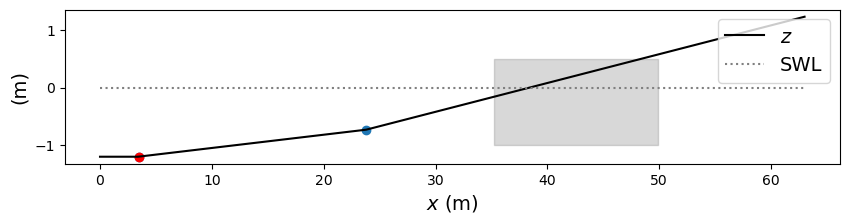

In [9]:
# NOTE: Doing something weird with the (len(i...)+0.5) to make the indices/array sizes weird -- make sure this is ok
# GIVENS: lab domain
lab_slope = 1/20 #1/43.5 #1/32
lab_length = 63
lab_depth = 1.5 + 0.48 #1.2 + 0.48 #1.5+0.48
lab_beach = 1.36 #1.7
isComposite = True

# set up bathymetry based on swl
def create_bathy(swl, lab_slope, lab_length, lab_depth, lab_beach, isComposite):
    dx = 0.1
    x = np.arange(0, lab_length + dx, dx)
    d = np.zeros_like(x)
    ioffbeach = indices_between(x, ft2m(11.11+0.31), ft2m(11.11+0.31+66.7)) # this is a list of indices for the "offshore" 1:43.5 slope
    
    if lab_slope < 1/43.5: # if shallower than 1:43.5, it HAS to be a composite slope bc the "offshore slope" is built in
        #print("composite slope due to shallow slope")
        # create offshore slope
        slope_off = 1/43.5
        off_depth = ft2m(66.7)*slope_off
        d[ioffbeach] =  np.arange(0, off_depth + dx * slope_off, dx * slope_off)[1:]
        # create experiment slope
        iexptslope = np.arange(ioffbeach[-1]+1, len(x)) # list of indices from end of offshore slope to end of tank
        d[iexptslope] = np.arange(d[ioffbeach[-1]] + dx * lab_slope, d[ioffbeach[-1]] + dx * lab_slope * (len(iexptslope)+0.5), dx * lab_slope)
    elif isComposite:
        #print("composite slope due to user input")
        # create offshore slope
        slope_off = 1/43.5
        off_depth = ft2m(66.7)*slope_off
        d[ioffbeach] =  np.arange(0, off_depth + dx * slope_off, dx * slope_off)[1:]
        # create experiment slope
        iexptslope = np.arange(ioffbeach[-1]+1, len(x)) # list of indices from end of offshore slope to end of tank
        d[iexptslope] = np.arange(d[ioffbeach[-1]] + dx * lab_slope, d[ioffbeach[-1]] + dx * lab_slope * (len(iexptslope)+0.5), dx * lab_slope)
    else:
        #print("uniform slope steeper than or equal to 1:43.5")
        ifull = np.arange(ioffbeach[0], len(x), 1)
        d[ioffbeach[0]:] = np.arange(0, lab_slope * dx * (len(ifull)), dx*lab_slope)
    
    #iflat = find_closest_index(d[ioffbeach[-1]+1:ibeach[-1]], d[ioffbeach[-1]])
    #d[ioffbeach[-1]+1:iflat+ioffbeach[-1]] = d[ioffbeach[-1]]
    #d[:ioffbeach[0]] = 0
    
    # define water depth
    h = -(d-swl)
    
    # window
    winloc = ft2m(115.41+0.31+np.array([0, 48]))

    return x, d, h, ioffbeach, winloc

x, d, h, ioffbeach, winloc = create_bathy(swl, lab_slope, lab_length, lab_depth, lab_beach, isComposite)
# Create a plot
fig, ax = plt.subplots(1, figsize=(10, 2))
ax.plot(x, -h, lw=1.5, color='k', label='$z$')
ax.plot(x, np.zeros_like(h), lw=1.5, color='grey', linestyle=':', label='SWL')
ax.scatter([x[ioffbeach[0]], x[ioffbeach[-1]]], [-h[ioffbeach[0]], -h[ioffbeach[-1]]]) # ioffbeach[-1] is the shoreward end of set 1:43.5 slope
ax.scatter([x[ioffbeach[0]]], [-h[ioffbeach[0]]], color='red')
ax.fill_betweenx([-1, 0.5], winloc[0], winloc[1], color='gray', alpha=0.3)
font_size = 14
ax.set_xlabel('$x$ (m)', fontsize=font_size)
ax.set_ylabel('(m)', fontsize=font_size)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=font_size)
plt.ioff()
plt.show()

### Peakfinder
A. Juang, 2/5/25

Created the more general findpeaks first, then made a plot (see a few cells down) to verify it works

Then created findMinH since that's all we are missing in shoalwave

In [10]:
def findpeaks(wstimeseries):
    dz = [wstimeseries[i+1] - wstimeseries[i] for i in range(len(wstimeseries)-1)]
    dz.append(-99) # not really needed but it helps w/ thinking about indices since dz will be one shorter than wstimeseries ("missing" element at right end)
    dz = np.array(dz)
    indices = np.where((dz[:-1] >=0) & (dz[1:] < 0))[0]
    heights = wstimeseries[indices + 1]
    maxHeight = max(heights)
    maxInd = np.where(wstimeseries == maxHeight)[0]
    minHeight = min(heights)
    minInd = np.where(wstimeseries == minHeight)[0]
    return maxHeight, maxInd, minHeight, minInd

def findMinH(wstimeseries):
    dz = [wstimeseries[i+1] - wstimeseries[i] for i in range(len(wstimeseries)-1)]
    dz.append(-99) # not really needed but it helps w/ thinking about indices since dz will be one shorter than wstimeseries ("missing" element at right end)
    dz = np.array(dz)
    indices = np.where((dz[:-1] >=0) & (dz[1:] < 0))[0]
    heights = wstimeseries[indices + 1]
    minHeight = min(heights)
    return minHeight

## Wave field

### Bulk statistics and timeseries

$$\omega^2 = gk \tanh(kh)$$  
$$\eta = a_1 \cos(\omega_1 t - k_1 x + \phi_1) + a_2 \cos(\omega_2 t - k_2 x + \phi_2)$$
wave group period ($T_g$)
$$T_g = \frac{1}{f} = \frac{1}{f_1 - f_2}$$
where the peak wave period is:
$$T_p = \frac{1}{f_p} = \frac{2}{f_1 + f_2}$$
and $f_p$ is the average frequency.

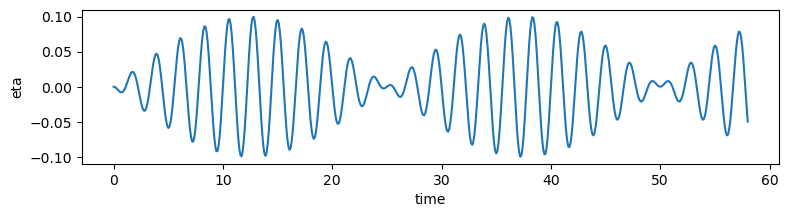

In [11]:
def calc_wave_field(a1, a2, f1, f2, swl):
    # bichromatic wave period and wavelength:
    T = 2 / (f1 + f2)
    Tg = 1 / (f1 - f2)
    [omega, k0] = calc_omega_k(1/T,swl)
    L0 = 2 * np.pi / k0
    
    # max height
    H0 = 2 * (a1 + a2)
    a0 = H0 / 2
    h0 = swl
    
    # calc omega, k
    [omega1, k1] = calc_omega_k(f1,swl)
    [omega2, k2] = calc_omega_k(f2,swl)
    
    # Define the parameters
    xp = 0#np.arange(0, 58.1, 0.1)#200.1, 0.1)
    tp = np.arange(0, 58.1, 0.1)#200.1, 0.1)
    
    # define phase lags
    phi1 = 180
    phi2 = 0
    
    # Define the wave expressions
    eta0 = a1 * np.cos(omega1 * tp - k1 * xp + np.deg2rad(phi1)) + a2 * np.cos(omega2 * tp - k2 * xp + np.deg2rad(phi2))

    Hmin = findMinH(eta0)

    return T, Tg, omega, k0, L0, H0, a0, h0, omega1, k1, omega2, k2, xp, tp, phi1, phi2, eta0, Hmin

a1 = 0.05
a2 = 0.05
f1 = 0.43
f2 = 0.47
swl = 1.3
T, Tg, omega, k0, L0, H0, a0, h0, omega1, k1, omega2, k2, xp, tp, phi1, phi2, eta0, Hmin = calc_wave_field(a1, a2, f1, f2, swl)

fig, ax = plt.subplots(1, figsize=(9, 2))
ax.plot(tp, eta0)
plt.xlabel('time')
plt.ylabel('eta')
plt.show()
#print(eta0)

### Check that peakfinder works

0.09973176031323003
0.0024924965005847857


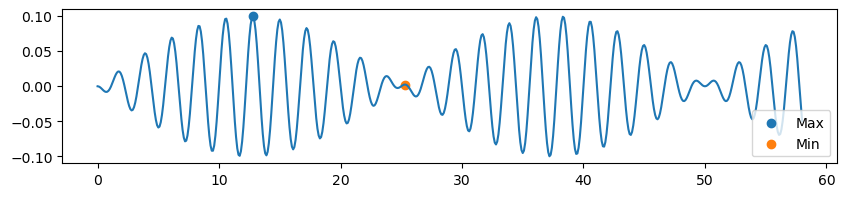

In [12]:
maxH, maxI, minH, minI = findpeaks(eta0)
print(maxH)
print(minH)
fig, ax = plt.subplots(1, figsize=(10, 2))
ax.plot(tp, eta0)
ax.scatter(tp[maxI], maxH, label='Max')
ax.scatter(tp[minI], minH, label='Min')
ax.legend(loc='lower right')
plt.show()

## Shoal wave
Shoal waves to breaking, assuming linear wave theory

In [13]:
def shoal_wave(T, Tg, H0, theta0, gammab, h, eta0, Hmin, H_IG):
    wave =  waveshoal_h_nonmono(T, H0, theta0, gammab, h) # this is MAX WAVE
    wave_IG =  waveshoal_h_nonmono(Tg, H_IG, theta0, gammab, h) # CAUTION: H is hardcoded, needs to be updated
    wave_half =  waveshoal_h_nonmono(T, H0/2, theta0, gammab, h)
    geomscale = H0/1 # more or less 0.05m:1m
    if Hmin < 0.0005:
        print("Using H_min = 0.0005m")
        wave_min = waveshoal_h_nonmono(T, 0.0005, theta0, gammab, h) # this is MIN WAVE HEIGHT
    else:
        wave_min = waveshoal_h_nonmono(T, Hmin, theta0, gammab, h) # this is MIN WAVE HEIGHT

    L = wave['L']
    H = wave['H']
    ib = wave['breaking_index'] + 1 # offset maybe due to the transition between matlab and python?
    hb = wave['breaking_depth'] # water depth at breaking
    #print(hb)
    Hb = wave['breaking_height'] # wave height at breaking
    theta = wave['theta']
    ab = Hb / 2 # amplitude at breaking
    Lb = L[ib] # wavelength at breaking
    thetab = theta[ib] # angle at breaking
    etab = eta0 * (Hb / H0) # as a proxy for the water surface elevation near breaking, increase eta based on shoaling. 
    etab[np.isnan(etab)] = 0
    # NOTE that linear wave theory does NOT hold here and therefore, this does not represent the water surface near breaking accurately.

    return wave, wave_IG, wave_half, wave_min, L, H, ib, hb, Hb, theta, ab, Lb, thetab, etab

## Runup
Based on empirical data from Stockdon 2006. Checked against equation 19 in paper on 12/19/24
Are we sure we're in deep water regime at wavemaker - do we need to reverse shoal (eg measurements at 20m wave buoy)
Is the slope appropriate? - a lot of work since this paper has shown that on a beach-by-beach basis, this isn't necessarily perfect. 
Need to consider eg if beach is barred, nearshore slope - which slope is being used
Are the h0 & l0 in deep water?
Think about each term and its contribution to the total runup
Swash model will give runup on wave by wave basis

In [14]:
def calculate_runup(slope, Hsig, L):
    runup = 1.1 * (0.35 * slope * math.sqrt(Hsig * L) + 0.5 * math.sqrt(Hsig * L) * (0.563 * (slope ** 2) + 0.004))
    return runup

# sample values
# H0 = ?
# L0 = ?
# runup = calculate_runup(cmpst_slope, H0, L0)
# irunup = find_closest_index(d, runup+swl)
#print(runup) 

## Orbital velocities

**Orbital velocities and excursion at bottom boundary**
$$
\tilde{u}_{b} = a \frac{gT}{L} \frac{\cosh [2 \pi (z+d)/L]]}{\cosh (2 \pi d/L)} cos \theta
$$
where $\tilde{u}_{b} = \sqrt{2}u_{rms}$.

$$
\tilde{a}_{b} = \frac{\tilde{u}_{b}}{\omega}
$$

Here, we use values at breaking and at the wavemaker:

In [15]:
def wave_orbital_velocity(a, T, L, z, h, theta):
    g = 9.81
    u = a * ((g*T)/L) * ((np.cosh(2*np.pi*(z+h)/L)) / (np.cosh(2*np.pi*h/L))) * np.cos(np.radians(theta))
    w = a * ((g*T)/L) * ((np.sinh(2*np.pi*(z+h)/L)) / (np.cosh(2*np.pi*h/L))) * np.cos(np.radians(theta))
    ao = u / (2 * np.pi / T)
    return u, w, ao

Calculate bottom orbital velocities and excursion at breaking

## Ustar
**Ustar from the frictional velocity or shear velocity**  
The frictional coefficient is
$$
f_w = \exp\left[ 5.213 \left( \frac{2.5 d_{50}}{\tilde{a}_{b}} \right) ^{0.194} -5.977 \right]
$$

**Shear velocity**
bed shear stress is
$$
\tau_{bw} = \frac{2}{3\pi}\rho_ff_w \tilde{u}_{b}^2~~[\mathrm{N/m}^2]
$$
such that
$$
u_* = \sqrt{\frac{\tau_{bw}}{\rho_f}} = \sqrt{\frac{2f_w}{3\pi}} \tilde{u}_{b}
$$

**Frictional velocity**
$$
u_* = \sqrt{f_w} u_{rms} = \sqrt{\frac{f_w}{2}}\tilde{u}_{b}
$$

Note, the shear velocity is less than the frictional velocity method by a factor of 0.65. 

**<span style="color:red;">For now, proceed with the shear velocity method at breaking.</span>**

In [16]:
def calculate_fw(D50, ab):
    fw = np.exp(5.213 * (2.5 * D50 / ab) ** 0.194 - 5.977)
    return fw

def calculate_taub(rhof, fw, ub):
    taub = (2 / (3 * np.pi)) * rhof * fw * (ub ** 2)
    return taub

def calculate_ustar(tau, rhof):
    ustar = np.sqrt(tau / rhof)
    return ustar

## Hydrodynamic scaling parameters

### Reynolds number 
The flow conditions near the bed can be divided in laminar, smooth turbulent and rough turbulent. These regimes can be predicted with the grain size Reynolds number:
$$
Re_{gs} = \frac{\tilde{u}_{b,\mathrm{max}} d_{50}}{\nu} =\frac{\sqrt{2} u_{rms} d_{50}}{\nu}
$$
and the wave boundary layer Reynolds number:
$$
R_{wbl} = \frac{ \tilde{u}_{b,\mathrm{max}} a_b}{\nu}=\frac{\sqrt{2}u_{rms}a_b}{\nu}
$$

In [17]:
def calculate_Re_wbl(ub, ab, nu):
    Re = ub * ab / nu
    if Re <= 2000:
        print('Laminar Flow')
    elif Re > 2000 and Re <= 4000:
        print('Unstable Flow')
    elif Re > 4000:
        print('Turbulent Flow')
    return Re

def calculate_Re_gs(ustar, D50, nu):
    Re = ustar * D50 / nu
    return Re

### Froude number
$$
Fr = \frac{H \omega}{2 \sqrt{gh}}
$$
or an alternative: 
$$
Fr = \frac{\tilde{a}_{b}}{2 \sqrt{gh}}
$$

$Fr<1$ subcritial  
$Fr = 1$ critical  
$Fr > 1$ supercirtical (fast rapid)

In [18]:
def calculate_Fr(H, omega, g, h):
    Fr = H * omega / (2 * np.sqrt(g * h))
    # Fr = ub/(2*np.sqrt(g*h))
    if Fr < 1:
        print('Subcritical')
    elif Fr == 1:
        print('Critical')
    elif Fr > 1:
        print('Supercritical')
    return Fr

### Iribarren Number
This is typically based on deep water wave conditions.
$$
 \zeta = \frac{\beta}{\sqrt{H_s/L_0}}
$$

$\zeta$ <0.4: Spilling  
$0.4<\zeta<2$: Plunging  
$\zeta>2$: Collapsing or surging

In [19]:
def calculate_zeta(beta, H, T):
    g = 9.81
    d = 1000
    L0 = T * np.sqrt( g * d )
    zeta = beta / np.sqrt(H / L0)
    # if zeta <= 0.4:
    #     print('Spilling')
    # elif zeta > 0.4 and zeta <= 2:
    #     print('Plunging')
    # elif zeta > 2:
    #     print('Collapsing or surging')
    return zeta

### Ursell number
The Ursell number relates the skewness and asymmetry and quantifies the nonlinearity:
$$
Ur = \frac{3}{8} \frac{H_{m,0} k}{(kh)^3}
$$
For small Ursell numbers, the skewness and asymmetry both approach zero and the waves have a sinusoidal shape, and thus waves having small Ursell numbers do not result in net sediment transport. For $Ur\sim 1$, the skewness is maximum and the asymmetry is small and the waves have a skewed shape. For large Ursell numbers, the skewness approaches 0 and the asymmetry is maximum, resulting in an asymmetric wave shape. In this way, if the wave shape is known, the Ursell number can be predicted and consequently the size and direction of sediment transport at a certain location can be predicted. 

Skewness:
$$
Sk = B \cos(\psi)
$$
Assymetry:
$$
As = B \sin (\psi)
$$
where
$$
B = \frac{0.857}{1+\exp{\frac{-0.471-\log(Ur)}{0.297}}}
$$
and
$$
\psi = -90^{\circ}+90^{\circ}\tanh\left(\frac{0.815}{Ur^{0.672}}\right)
$$

**<span style="color:red;">Need to figure out regimes.</span>**

In [20]:
def calculate_ursell(H, k, h):
    # Calculate Ur
    Ur = (3/8) * H * k / ((k * h) ** 3)
    
    # Calculate B
    B = 0.857 / (1 + math.exp((-0.471 - math.log(Ur) / 0.297)))
    
    # Calculate psi
    psi = -math.pi/2 + (math.pi/2) * math.tanh(0.815 / (Ur ** 0.672))
    
    # Calculate Sk and As
    Sk = B * math.cos(psi)
    As = B * math.sin(psi)
    
    return Ur, Sk, As

## Sediment transport scaling parameters

### Settling velocity: 
Assuming laminar settling, spherical particle, discrete particle, steady state, Stokes settling velocity is computed as:
$$
W_s = \frac{D^2\Delta \rho g}{18 \mu}
$$
where $D$ is the particle diameter ($D_{mm} = 2^{-\phi}$), $\Delta\rho$ is the difference between the density of the sediment ($\rho_s$) and fluid ($\rho_f$), $g$ is gravity, and $\mu$ is dynamic viscosity of the fluid.

In [21]:
def calculate_ws(D50, drho, g, mu):
    ws = ((D50 ** 2) * drho * g) / (18 * mu)
    return ws

### Dean number
$$
\Omega = \frac{H_{rms}}{w_s T_p}
$$

$\Omega$ <1: reflective beach  
$1<\Omega<6$: intermediate beach   
$\Omega>6$: dissipative beach

In [22]:
def calculate_Omega(H, ws, T):
    Omega = H / (ws * T)
    if Omega <= 1:
        print('Reflective')
    elif Omega > 1 and Omega <= 6:
        print('Intermediate')
    elif Omega > 6:
        print('Dissipative')
    return Omega

### Rouse number
$$
Rou = \frac{w_s}{\kappa u^*}
$$

Assuming the von Karmen''s constant $\kappa \approx 0.41$

$Rou$ <0.8: Wash load  
$0.8<Rou<1.2$: Suspended load (100%)  
$1.2<Rou<2.5$: Suspended load (50%)  
$Rou>2.5$: Bed load

In [23]:
def calculate_Rou(ws, kappa, ustar):
    Rou = ws / (kappa * ustar)
    #if Rou <= 0.8:
    #    print('Wash load')
    #elif Rou > 0.8 and Rou <= 1.2:
    #    print('Suspended load (100%)')
    #elif Rou > 1.2 and Rou <= 2.5:
    #    print('Suspended load (50%)')
    #elif Rou > 2.5:
    #    print('Bed load')
    return Rou

### Shields Number

$$
\theta_{\omega} = \frac{\langle \tau_{bw} \rangle}{(\rho_s-\rho_f)gd_{50}}
$$

$$
Re_* = \frac{ \sqrt{\frac{\tau_{bw}}{ \rho_f}}d_{50}}{\nu}
$$

In [24]:
def calculate_shields(taub, rhos, rhof, D50, nu):
    g = 9.81
    shields = taub / ((rhos-rhof) * g * D50)
    Restar = np.sqrt(taub / rhof) * D50 / nu
    return shields, Restar

### Stokes Number 
<!-- **<span style="color:red;">Not certain about this number.</span>**  
The settling velocity (also called the "fall velocity" or "terminal velocity") is a function of the particle Reynolds number. Generally, for small particles (laminar approximation), it can be calculated with Stokes' Law. For larger particles (turbulent particle Reynolds numbers), fall velocity is calculated with the turbulent drag law. Dietrich (1982) compiled a large amount of published data to which he empirically fit settling velocity curves. Ferguson and Church (2006) analytically combined the expressions for Stokes flow and a turbulent drag law into a single equation that works for all sizes of sediment, and successfully tested it against the data of Dietrich.

$$
w_s = \frac{RgD^2}{C_1 \nu+(0.75 C_2 RgD^3)^{0.5}}
$$

where $R$ is specific gravity and $C_1$ and $C_2$ are constants related to shape and smoothess. Here I choose conditions for natural grains with sieve diameters $C_1$ =18, $C_2$ = 1 (for nominal diamters $C_1$ =20, $C_2$=1.1)

For known quantities and seive diamater for natural grains:
$$
w_s = \frac{16.17 D^2}{1.8\times 10^{-5}+(12.1275D^3)^{0.5}}
$$

**OR** -->
A dimensionless number characterising the behavior of particles suspended in a fluid flow. Ratio of the characteristic time of a particle to characteristic time of the flow
$$
Stk =\frac{t u }{l}
$$
where $t$ is the relaxation time, $u$ is the fluid velocity well away from the obstacle, $l$ is the characteristic dimension of the obstacle. In other words:
$$
Stk = \frac{t u_*}{d_{50}}
$$
where
$$
t = \frac{\rho_s d_{50}^2}{18 \mu}
$$
Thus,
$$
Stk = \frac{\rho_s D u_*}{18 \mu }
$$

In [25]:
# stokes fall velocity
# def calculate_stk(D50):
#     stk = 16.17 * D50**2 / ((1.8e-5) + (12.1275 * D50**3)**0.5)
#     return stk

# another stokes? 
def calculate_Stk(rhos, D50, mu, ustar):
    Stk = (rhos * D50 * ustar) / (18 * mu)
    return Stk

# Interactive widget - effect of wave conditions on hydrodynamic and sediment transport indicators

In [26]:
### Create a plot
# Add: third subplot showing orbital velocities
# Add: fourth subplot showing waves/wave groups for the chosen amplitudes and frequencies
# Modify? set datum at floor of flume
# Clarify: what is the total height of the flume? (to modify swl slider range)

%matplotlib

def update_plot(a1, a2, f1, f2, swl, slope_h, isComposite,saveFigure):
    ### CALCULATIONS ###

    # wave time series
    t = np.arange(0, 30, 0.1) # timesteps
    wave1 = a1*np.cos(2*np.pi*f1*t) # Christine uses omega*t inside parentheses. Should be the same.
    #wave2 = a2*np.sin(2*np.pi*f2*t+np.pi/2)
    wave2 = a2*np.cos(2*np.pi*f2*t)
    added = wave1 + wave2
    etaIG, aIG = calc_LH_boundwave(a1, a2, f1, f2, swl, t)

    # Hydrodynamics
    x, d, h, ioffbeach, winloc = create_bathy(swl, 1/slope_h, lab_length, lab_depth, lab_beach, isComposite)
    T, Tg, omega, k0, L0, H0, a0, h0, omega1, k1, omega2, k2, xp, tp, phi1, phi2, eta0, Hmin = calc_wave_field(a1, a2, f1, f2, swl)
    wave, wave_IG, wave_half, wave_min, L, H, ib, hb, Hb, theta, ab, Lb, thetab, etab = shoal_wave(T, Tg, H0, theta0, gammab, h, eta0, 0.02, aIG*2)
    
    # Runup
    r2 = calculate_runup(1/slope_h, H0, L0)
    # Sediment transport
    ws = calculate_ws(D50, drho, g, mu) # settling velocity; not dependent on any of the variables that vary through the profile
    # Orbital velocities at wavemaker, bottom boundary
    [ub0, wb0, ao0] = wave_orbital_velocity(eta0, T, L0, -h0, h0, theta0)
    [ub0_max, wb0_max, ao0_max] = wave_orbital_velocity(a0, T, L0, -h0, h0, theta0)
    # Orbital velocities at breaking, bottom boundary
    [ubb, wbb, aob] = wave_orbital_velocity(etab, T, Lb, -hb, hb, thetab)
    [ubb_max, wbb_max, aob_max] = wave_orbital_velocity(ab, T, Lb, -hb, hb, thetab)
    # Other orbital velocities, bottom boundary
    orbinds = np.arange(20, 501, 20)
    orbinds = orbinds[orbinds < ib] # remove indices shoreward of breaking
    ub = [] # is there a way to shorten this list in python
    wb = []
    ao = []
    fw = []
    taub = []
    us = [] # us = ustar
    Rou = []
    Shl = []
    Xi = []
    Urs = []
    Sks = []
    As = []
    for i in orbinds:
        ubx, wbx, aox = wave_orbital_velocity(eta0*H[i]/H0, T, L[i], -h[i], h[i], theta[i])
        ub.append(ubx)
        wb.append(wbx)
        ao.append(aox)
        fw.append(calculate_fw(D50, max(aox)))
        taub.append(calculate_taub(rhof, max(fw), max(ubx)))
        us.append(calculate_ustar(max(taub), rhof))
        Rou.append(calculate_Rou(ws, kappa, calculate_ustar(max(taub), rhof)))
        shields, restar = calculate_shields(max(taub), rhos, rhof, D50, nu)
        Shl.append(shields)
        Xi.append(calculate_zeta(1/slope_h, H[i], T))
        Ur, Sk, Asym = calculate_ursell(H[i], 2*np.pi/L[i], h[i])
        Urs.append(Ur)
        Sks.append(Sk)
        As.append(Asym)

    ### CREATE FIGURE ###
    # Global plot setup
    fig, ax = plt.subplots(nrows=4, ncols = 2, figsize=(20, 13))
    plt.subplots_adjust(hspace=0.5)
    plt.rcParams["font.family"] = "Helvetica"

    # SUBPLOT 0,0: FLUME PROFILE VIEW    
    # Removed runup-related lines
    ax[0,0].set_title('Waves, water levels, and location of breaking')
    ax[0,0].plot(x, d-swl, lw=3, color='k', label='$z$', zorder=1)
    ax[0,0].plot(x, H, lw=1.5, color='cyan', label='$H_{max}$')
    ax[0,0].plot(x, wave_min['H'], lw=1.5, color='cornflowerblue', label='$H_{min}$')
    ax[0,0].plot(x, wave_IG['H'], lw=1.5, color='salmon', label='$H_{IG}$')
    lastH = H[~np.isnan(H)][-1] if np.any(~np.isnan(H)) else None
    #xNoRunup = np.interp(lastH, d-swl, x)
    #ax[0,0].scatter(xNoRunup, lastH, lw = 1.5, color='r', label = '$H_{max}$')
    xRunup = np.interp(lastH+r2, d-swl, x)
    ax[0,0].scatter(xRunup, lastH+r2, lw=1.5, color='pink', label='$H_{max}$ + R2')
    ax[0,0].plot(x, wave_half['H'], lw=1.5, color='b', label='$H_{1/2}$')
    ax[0,0].plot(x, np.zeros_like(h), lw=1.5, color='grey', linestyle=':', label='SWL')
    ax[0,0].scatter(x[ib], (d-swl)[ib], color = 'green', s=80, marker='^', label='$H_{max}$ breakpt', zorder=10)
    ax[0,0].scatter(x[wave_half['breaking_index']], (d-swl)[wave_half['breaking_index']], color = 'green', s = 80, marker = 'd', label='$H_{1/2}$ breakpt', zorder=10)
    ax[0,0].scatter(x[wave_min['breaking_index']], (d-swl)[wave_min['breaking_index']], color = 'green', s = 80, marker = 'v', label='H=2cm breakpt', zorder=10)
    if isComposite | (slope_h > 43.5):
        ax[0,0].scatter(x[ioffbeach[-1]], -h[ioffbeach[-1]], s=30)
    ax[0,0].fill_betweenx([-1, 0.5], winloc[0], winloc[1], color='gray', alpha=0.3, zorder=1)
    font_size = 10
    ax[0,0].set_ylabel('Elevation (m)', fontsize=font_size)
    ax[0,0].legend(loc='upper left', fontsize=font_size, ncol=2) #, bbox_to_anchor=(1, 1)
    ax[0,0].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    ax[0,0].set_xlim(0,75)
    ax[0,0].grid(True)
    
    # SUBPLOT 1,0: WAVELENGTHS AND DEEP/SHALLOW WATER REGIME
    ax[1,0].set_title('Wavelengths & kh')
    ax[1,0].plot(x,wave['L'],color='blue',label='$L_{0,sg}$') # units??
    ax[1,0].plot(x,wave_IG['L'],color='darkviolet',label='$L_{0,ig}$')
    #ax[1].plot(x,(d-swl)*10,color='k',label='z (x10 for display)')
    ax[1,0].legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=font_size)
    ax[1,0].set_ylabel('Wavelength (m, solid)', fontsize=font_size)
    ax[1,0].set_xlim(0,75)
    ax[1,0].grid(True)
    ax1 = ax[1,0].twinx()
    ax1.plot(x, 2*math.pi/np.where(wave['L']==0, np.nan, wave['L'])*h, linestyle='-.', color='blue',label='$k_{sg}h$', linewidth=1.3)
    ax1.plot(x, 2*math.pi/np.where(wave_IG['L']==0, np.nan, wave_IG['L'])*h, linestyle='-.', color='darkviolet', label='$k_{ig}h$', linewidth=1.3)
    #print('wave[L]*h: '+str(wave['L']*h)+'. wave_IG[L]*h: '+str(wave_IG['L']*h))
    #ax1.plot(np.linspace(0, 63, len(h)), np.array(2*math.pi/h).T, color='grey', linestyle='--', label='Deep->shallow')
    ax1.plot([0, 63], [np.pi, np.pi], color='grey', linestyle='--', label=r'kh = $\pi$ (deep)')
    ax1.plot([0, 63], [np.pi/10, np.pi/10], color='grey', linestyle='-.', label=r'kh = $\pi/10$ (shallow)')
    #print(np.array(2*math.pi/h).T)
    ax1.legend(loc='lower right', fontsize=font_size)
    ax[1,0].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    yl = plt.gca().get_ylim() # get y-limits to plot window
    ax1.fill_betweenx(yl, winloc[0], winloc[1], color='gray', alpha=0.3, zorder=2)
    ax1.set_ylabel('kh (dashed)')

    # SUBPLOT 2,0: IRIBARREN NUMBER
    ax[2,0].set_title('Iribarren number')
    ax[2,0].set_xlim(0,75)
    ax[2,0].grid(True)
    ax[2,0].scatter(x[orbinds], Xi, color='k', marker='x', label='Iribarren number',zorder=10)
    ax[2,0].fill_between([0, 75], 0, 0.4, color='paleturquoise', alpha=0.5, zorder=1,label='Spilling (Ref: SD stormy)', edgecolor='none', hatch='//')
    ax[2,0].fill_between([0, 75], 0.4, 2, color='darkturquoise', alpha=0.5, zorder=1,label='Plunging (Ref: SD summer)', edgecolor='none')
    ax[2,0].fill_between([0, 75], 2, 2.5, color='steelblue', alpha=0.5, zorder=1, label='Collapsing', edgecolor='none', hatch='x')
    yl = ax[2,0].get_ylim() # get y-limits to plot window
    ax[2,0].fill_betweenx(yl, winloc[0], winloc[1], color='gray', alpha=0.3)
    ax[2,0].legend(loc='upper right', fontsize=font_size)
    ax[2,0].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    ax[2,0].set_ylabel(r'$\zeta$')

    # SUBPLOT 3,0: URSELL NUMBER
    ax[3,0].set_title('Ursell number')
    ax[3,0].scatter(x[orbinds], Urs, color='k', marker='x', label='Ursell number',zorder=10)
    ax3 = ax[3,0].twinx()
    ax3.plot(x[orbinds], Sks, label='Skewness')
    ax3.plot(x[orbinds], As, label='Asymmetry')
    ax[3,0].set_xlim(0,75)
    ax[3,0].grid(True)
    yl = ax[3,0].get_ylim() # get y-limits to plot window
    ax[3,0].fill_betweenx(yl, winloc[0], winloc[1], color='gray', alpha=0.3)
    ax[3,0].legend(loc='upper right', fontsize=font_size)
    ax[3,0].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    ax[3,0].set_ylabel('U')
    ax3.set_ylabel('Skewness and asymmetry')
    ax3.legend(loc='lower right', fontsize=font_size)
    
    # SUBPLOT 0,1: ORBITAL VELOCITIES
    ax[0,1].set_title('Velocities at bottom boundary')
    ax[0,1].scatter(0, max(ub0), color='blue', label='Max orbital velocity\nat bottom boundary')
    ax[0,1].scatter(x[ib], max(ubb), color='blue', marker='^')
    ax[0,1].scatter(x[orbinds], [np.max(arr) for arr in ub], color='blue', zorder=10)
    ax[0,1].scatter(x[orbinds], us, color = 'skyblue', label='$U_{star}$')
    ax[0,1].legend(loc='upper right', fontsize=font_size)
    ax[0,1].set_ylabel('Velocities (m/s)')
    ax[0,1].set_xlim(0,75)
    ax[0,1].grid(True)
    ax[0,1].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    yl = ax[0,1].get_ylim() # get y-limits to plot window
    ax[0,1].fill_betweenx(yl, winloc[0], winloc[1], color='gray', alpha=0.3)

    # SUBPLOT 1,1: ROUSE NUMBER
    ax[1,1].set_title('Sediment transport regime')
    ax[1,1].scatter(x[orbinds], Rou, color='k', marker='x', label='Rouse number',zorder=10)
    ax[1,1].fill_between([0, 75], 0, 0.8, color='#cc9900', alpha=0.5, zorder=1,label='Wash load', edgecolor='none', hatch='//')
    ax[1,1].fill_between([0, 75], 0.8, 1.2, color='#ffff66', alpha=0.5, zorder=1,label='100% suspended load', edgecolor='none')
    ax[1,1].fill_between([0, 75], 1.2, 2.5, color='#66ff66', alpha=0.5, zorder=1, label='50% suspended load', edgecolor='none', hatch='x')
    yl = ax[1,1].get_ylim() # get y-limits to plot window
    ax[1,1].fill_between([0, 75], 2.5, yl[1], color='#006600', alpha=0.5, zorder=1, label='Bed load', edgecolor='none')
    ax[1,1].fill_betweenx(yl, winloc[0], winloc[1], color='gray', alpha=0.3)
    ax[1,1].plot([0, 53], [1.25, 1.25], color='dimgrey', linestyle='-.', label='Ref: SD stormy', zorder=9)
    ax[1,1].plot([0, 53], [1.69, 1.69], color='rosybrown', linestyle='--', label='Ref: SD summer', zorder=9)
    ax[1,1].grid(True)
    ax[1,1].set_xlim(0,75)
    ax[1,1].set_ylabel('Rouse number')
    ax[1,1].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    ax[1,1].legend(loc='upper right', fontsize=font_size)

    # SUBPLOT 2,1: SHIELDS NUMBER
    ax[2,1].set_title('Shields number')
    ax[2,1].scatter(x[orbinds], Shl, color='k', marker='x', label='Shields number',zorder=10)
    ax[2,1].plot([0, 75], [1.20, 1.20], color='dimgrey', linestyle='-.', label='Ref: SD stormy')
    ax[2,1].plot([0, 75], [0.66, 0.66], color='rosybrown', linestyle='--', label='Ref: SD summer')
    yl = ax[2,1].get_ylim() # get y-limits to plot window
    ax[2,1].fill_betweenx(yl, winloc[0], winloc[1], color='gray', alpha=0.3)
    ax[2,1].grid(True)
    ax[2,1].set_xlim(0,75)
    ax[2,1].set_xlabel('Distance from wavemaker (m)', fontsize=font_size)
    ax[2,1].legend(loc='upper right', fontsize=font_size)

    # SUBPLOT 3,1: WAVE GROUPINESS
    ax[3,1].plot(t, wave1, linestyle='-.', linewidth=0.8, label='Wave 1', color='mediumturquoise')
    ax[3,1].plot(t, wave2, linestyle='-.', linewidth=0.8, label='Wave 2', color='deepskyblue')
    ax[3,1].plot(t, added, linewidth=2, label='Combined wave', color='blue')
    ax[3,1].plot(t, etaIG, linewidth=2, label='Bound IG wave', color='tomato')
    ax[3,1].set_title('Wave groupiness')
    ax[3,1].set_xlabel('Time (s)')
    ax[3,1].set_ylabel('Amplitude (m)')
    ax[3,1].grid(True)
    ax[3,1].legend(loc='upper right', fontsize=font_size)

    #print(f"runup = {r2:.2f}m")
    
    if isComposite:
        filename = "a1_"+str(np.round(a1,2))+"_a2_"+str(np.round(a2,2))+"_f1_"+str(np.round(f1,2))+"_f2_"+str(np.round(f2,2))+"_swl"+str(np.round(swl,2))+"_hv"+str(np.round(slope_h,2))+"_comp.pdf"
        #filename = f"a1{round(a1)}_a2{round(a2)}_f1{round(f1)}_f2{round(f2)}_swl{round(swl)}_hv{round(slope_h)}_comp.pdf"
    else:
        filename = "a1_"+str(np.round(a1,2))+"_a2_"+str(np.round(a2,2))+"_f1_"+str(np.round(f1,2))+"_f2_"+str(np.round(f2,2))+"_swl"+str(np.round(swl,2))+"_hv"+str(np.round(slope_h,2))+".pdf"
    
    
    if saveFigure:
        plt.savefig("figures/"+filename)  

    plt.draw() # render plot

    return fig

interact(update_plot, 
         a1 = widgets.FloatSlider(min=0.002, max=0.15,step=0.005,value=0.05,description='a1 (m)'), 
         a2 = widgets.FloatSlider(min=0.001, max=0.15,step=0.005,value=0.05,description='a2 (m)'), 
         f1 = widgets.FloatSlider(min=0.001, max=1.5,step=0.01,value=0.50,description='f1 (1/s)'), 
         f2 = widgets.FloatSlider(min=0.01, max=1.51,step=0.01,value=0.43,description='f2 (1/s)'), 
         swl = widgets.FloatSlider(min=0.5, max=1.5,step=0.05,value=1.3,description='SWL (m)'),
         slope_h = widgets.FloatSlider(min=30, max=60,step=0.5,value=43.5,description='Slope (1:#)'),
         isComposite = widgets.Checkbox(value=False, description="enforce composite slope"),
         saveFigure = widgets.Checkbox(value=False, description="save figure to pdf")
)

         


Using matplotlib backend: module://matplotlib_inline.backend_inline


interactive(children=(FloatSlider(value=0.05, description='a1 (m)', max=0.15, min=0.002, step=0.005), FloatSli…

<function __main__.update_plot(a1, a2, f1, f2, swl, slope_h, isComposite, saveFigure)>

### check coincidence of the various parameters that vary in time
ubx, fw